# Introduction {-}

## Instructions {-}

Use Python to complete the project. Your code should produce all results requested below in a single run. Variable names should be meaningful. Input arguments should be displayed clearly for additional user testing. You just need to pick 2 formulas (model diffusion and implied volatility approximation) in the reference. You do not need to understand the whole document

## Questions {-}
1. Implement the implied volatility formula from SABR model.
2. Plot the implied vol. surface as a function of the model parameters $(\alpha, \nu, \beta, \rho)$.
3. Comment the impact of each parameter on the shape of the volatility
4. Price (ITM,ATM,OTM) European options under SABR model using Monte Carlo simulation
5. Compare the Monte Carlo option prices with the ones you get by using the SABR vol. approximation in Black's formula. Does your Monte Carlo simulation converge to the Black's price?

## References{-}
* Hagan, P., Kumar, D., Lesniewski, L, and D.E. Woodward (2002). "Managing Smile Risk," Wilmott Magazine.
* Fabrice Douglas Rouah. "The SABR Model".

## Framework {-}
The homework is an application of the SABR pricing framework given by: 
\begin{align*}
    df_t &= \alpha_t f_t^\beta dW_t^1 \\
    d\alpha_t &= \nu \alpha_t dW_t^2 \\
    E[dW_t^1dW_t^2] &= \rho dt
\end{align*}
with initial values $f_0$ and $\alpha_0 = \alpha$. In these 2 diffusions, $f_t$ is the forward price of the asset, $\alpha_t$ its volatility, $\nu$ the volatility of the volatility, $\beta$ the shape parameter of the forward price diffusion. $W_t^1$ and $W_t^2$ are two Brownian motions with correlation $\rho$.

# Implied volatility formula implementation

The price of a European call option given by Black's model is: 
\begin{align*}
    C_B(f,K,\sigma,r,T) = e^{-rT}[fN(d_+)-KN(d_-)]
\end{align*}
where $f$ is the current forward price, K is the strike price, $\sigma$ is the volatility and $T$ the time to maturity. And where:
\begin{align*}
    d_\pm = \frac{\ln{f/K}\pm \frac{1}{2}\sigma T}{\sigma \sqrt{T}}
\end{align*}
Using SABR model, we can replace $\sigma$ by the SABR implied volatility given by : 
\begin{align*}
    \sigma_{SABR}(K,T) &= \frac{\alpha  \bigg\{1 + \bigg[\frac{(1-\beta)^2}{24}\frac{\alpha^2}{(fK)^{1-\beta}} + \frac{1}{4}\frac{\rho \beta \nu \alpha}{(fK)^{(1-\beta)/2}} + \frac{2-3\rho^2}{24}\nu^2 \bigg] T \bigg\}}      {(fK)^{(1-\beta)/2} \bigg[1 + \frac{(1-\beta)^2}{24}\ln^2\frac{f}{K} + \frac{(1-\beta)^4}{1920}\ln^4\frac{f}{K}\bigg]} \times \frac{z}{\chi(z)} \\ 
    z &= \frac{\nu}{\alpha}(fK)^{(1-\beta)/2} \ln{f/K}\\
    \chi(z) &= \ln \bigg[ \frac{\sqrt{1-2\rho z + z^2}+z-\rho}{1-\rho} \bigg] 
\end{align*}
The parameters $\alpha, \beta, \nu,\rho$ have to be estimated using market data and are the same as the parameters in the diffusions in introduction, $f$ is given by the market. Then we get the implied volatility surface by considering $\sigma_{SABR}$ as function of $K$ and $T$.

In [1]:
import numpy as np 
%matplotlib inline
import matplotlib.pyplot as plt #3.3.4 needed, won't work with any other versions of mpl
plt.rcParams['figure.dpi'] = 150
from scipy.stats import norm

In [2]:
def vol(a,b,v,rho,K,f,T): 
    z = v/a * (f*K)**((1-b)/2) * np.log(f/K)
    X = np.log((np.sqrt(1 - 2*rho*z + z**2) + z - rho)/(1-rho))
    numer = a * (1 + (((1-b)**2)/24 * (a**2)/((f*K)**(1-b)) + 
                      (1/4) * (rho*b*v*a)/((f*K)**((1-b)/2)) + ((2-3*(rho**2))/24)*(v**2)) * T)     
    denom = (1 + ((1-b)**2)/24 * np.log(f/K)**2 + (1-b)**4/1920*np.log(f/K)**4) * (f*K)**((1-b)/2)
    return (numer/denom * z/X)

# Plots 
In this question, we will plot the implied volatility surface for time to maturity varying between 0 and 2 years and one volatility smile at 1 month to maturity. The parameters are fixed: 
\begin{align*}
\alpha &= 0.3,\\ 
\beta &= 1,\\ 
\nu &= 0.4 ,\\ 
\rho &= 0.1,
\\ f &= 15.
\end{align*}

In practice the parameters can be estimated using the sum of square errors (SSE) minimization between the market implied volatilities and the SABR implied volatilities.

In [3]:
T = 2 #years 
TTM =  0.119 #1 month 
alpha = 0.3 #a
beta = 1 #b
nu = 0.4 #v
rho = 0.1 #rho
price = 15 

## Volatility surface
The volatility surface can be plotted using the function $\sigma_{SABR}$ in question $1$ and taking $K$ and $T$ as variables. In our example, we choose $K \in [7.5,22.5]$ and $T \in [0,2]$

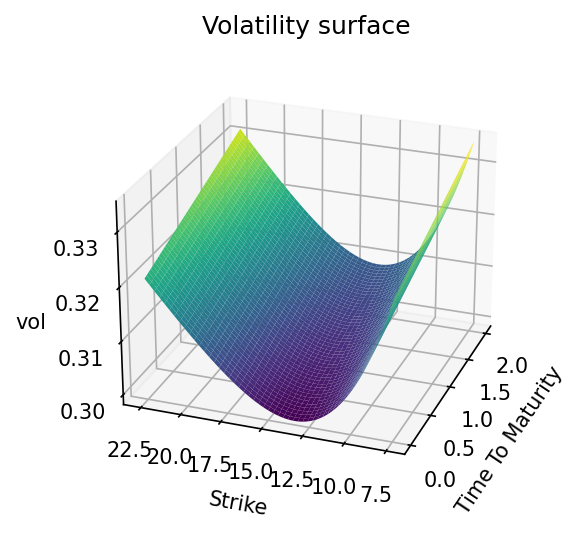

In [4]:
# x and y for surface 
x = np.linspace(0,2,50)
y = np.linspace(price*1.5,price*0.5,1000)
X, Y = np.meshgrid(x,y)

Z = vol(alpha,beta,nu,rho,Y,price,X)


ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z,
                cmap='viridis', edgecolor='none')
ax.set_xlabel('Time To Maturity')
ax.set_ylabel('Strike')
ax.set_zlabel('vol')
ax.view_init(25, 200)
ax.set_title(f"Volatility surface")
plt.show()

## Volatility smile
We fix $T = 0.119$ (1 month) and we plot the smile with the same parameters.

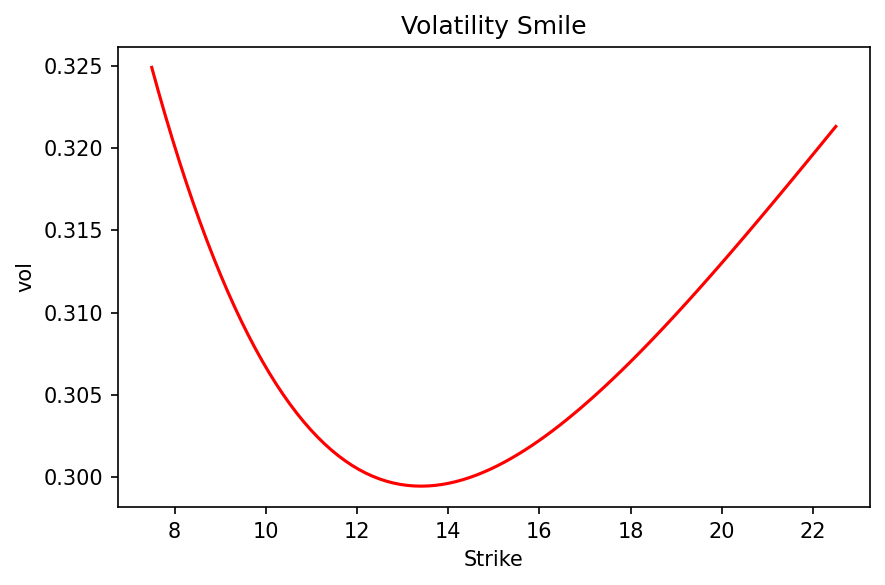

In [7]:
# x for smile
x1 = np.linspace(price*0.5,price*1.5,100)

y1 = vol(alpha,beta,nu,rho,x1,price,TTM)


fig, ax = plt.subplots()
ax.plot(x1,y1, 'r')
ax.set_title(f'Volatility Smile')
ax.set_ylabel('vol')
ax.set_xlabel('Strike')
plt.tight_layout()
plt.show()   

# Impact of parameters on the implied volatility
We want to know the effect of each parameter on the surface and on the smile. To do it, we make the parameters vary and see the effects on the surface and smile. We keep all parameters same as above.
## Impact of alpha

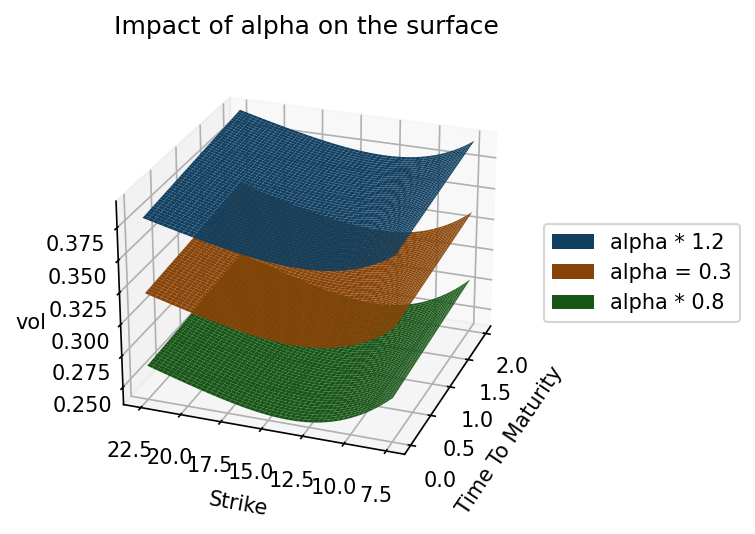

In [8]:
#3.1.1 alpha surface
Z1alpha = vol(alpha,beta,nu,rho,Y,price,X)
Z2alpha = vol(alpha*1.2,beta,nu,rho,Y,price,X)
Z0alpha = vol(alpha*0.8,beta,nu,rho,Y,price,X)
    
plt.figure()
ax = plt.axes(projection='3d')
ax.set_xlabel('Time To Maturity')
ax.set_ylabel('Strike')
ax.set_zlabel('vol')
ax.view_init(25, 200)
ax.set_title(f"Impact of alpha on the surface")
s2 = ax.plot_surface(X, Y, Z2alpha, label = 'alpha * 1.2')
s1 = ax.plot_surface(X, Y, Z1alpha, label = f'alpha = {alpha}')
s0 = ax.plot_surface(X, Y, Z0alpha, label = 'alpha * 0.8')
s2._facecolors2d=s2._facecolor3d
s2._edgecolors2d=s2._edgecolor3d
s1._facecolors2d=s1._facecolor3d
s1._edgecolors2d=s1._edgecolor3d
s0._facecolors2d=s0._facecolor3d
s0._edgecolors2d=s0._edgecolor3d
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

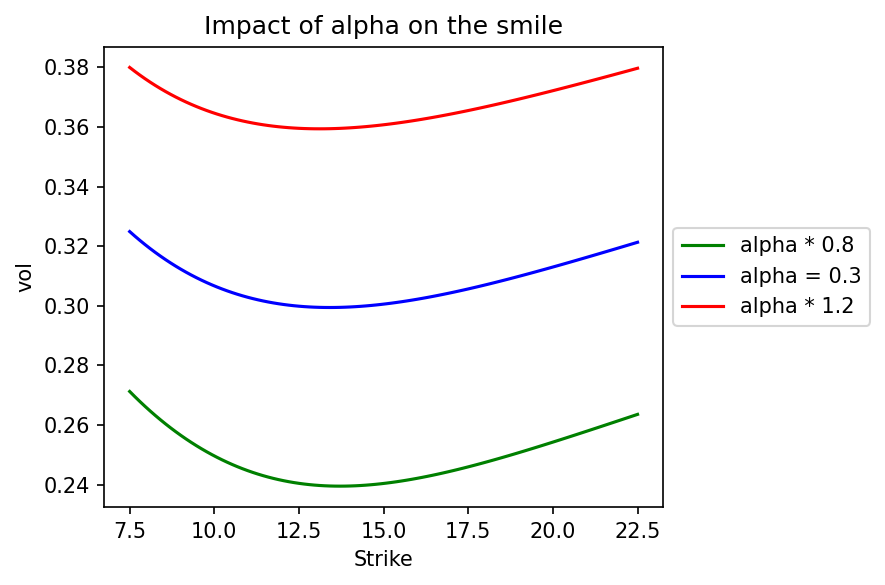

In [9]:
#3.1.2 alpha smile 
y1alpha = vol(alpha,beta,nu,rho,x1,price,TTM)
y2alpha = vol(alpha*1.2,beta,nu,rho,x1,price,TTM)
y0alpha = vol(alpha*0.8,beta,nu,rho,x1,price,TTM)

fig, ax = plt.subplots()
ax.plot(x1,y0alpha, 'r',color='g',label = 'alpha * 0.8')
ax.plot(x1,y1alpha, 'r',color = 'b',label = f"alpha = {alpha}")
ax.plot(x1,y2alpha, 'r',label = 'alpha * 1.2')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_title(f'Impact of alpha on the smile')
ax.set_ylabel('vol')
ax.set_xlabel('Strike')
plt.tight_layout()
plt.show()   

We can see that $\alpha$ has not a big impact on the shape of the surface but as alpha increases, the vertical position of the smile and the surface increases. 

## Impact of beta

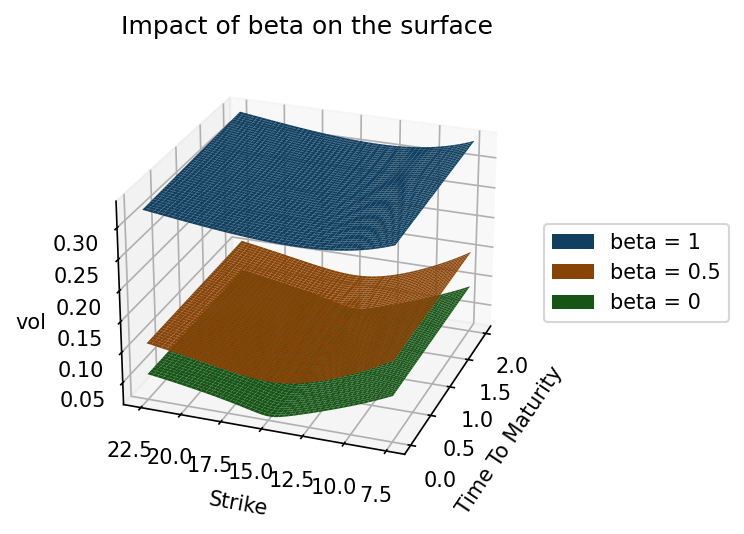

In [47]:
#3.2.1 beta surface
Zbeta05 = vol(alpha,1/2,nu,rho,Y,price,X)
Zbeta1 = vol(alpha,1,nu,rho,Y,price,X)
Zbeta0 = vol(alpha,0,nu,rho,Y,price,X)

plt.figure()
ax = plt.axes(projection='3d')
ax.set_xlabel('Time To Maturity')
ax.set_ylabel('Strike')
ax.set_zlabel('vol')
ax.view_init(25, 200)
ax.set_title(f"Impact of beta on the surface")
s2 = ax.plot_surface(X, Y, Zbeta1, label = 'beta = 1')
s1 = ax.plot_surface(X, Y, Zbeta05, label = 'beta = 0.5')
s0 = ax.plot_surface(X, Y, Zbeta0, label = 'beta = 0')
s2._facecolors2d=s1._facecolor3d
s2._edgecolors2d=s1._edgecolor3d
s1._facecolors2d=s1._facecolor3d
s1._edgecolors2d=s1._edgecolor3d
s0._facecolors2d=s0._facecolor3d
s0._edgecolors2d=s0._edgecolor3d
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

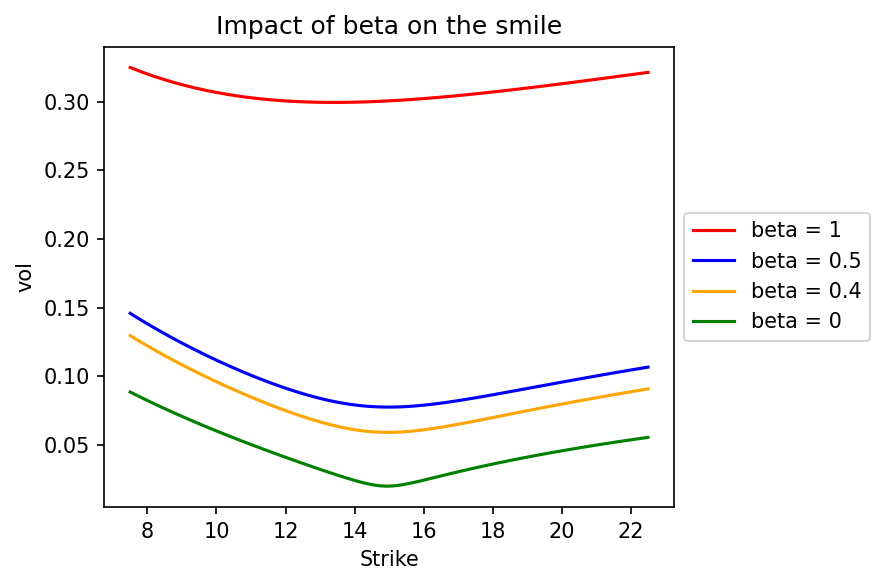

In [48]:
#3.2.2 beta smile 
y1beta = vol(alpha,0.5,nu,rho,x1,price,TTM)
y2beta = vol(alpha,1,nu,rho,x1,price,TTM)
y0beta = vol(alpha,0,nu,rho,x1,price,TTM)
y3beta = vol(alpha,0.4,nu,rho,x1,price,TTM)

fig, ax = plt.subplots()
ax.plot(x1,y2beta, 'r',label = 'beta = 1')
ax.plot(x1,y1beta, 'r',color = 'b',label = "beta = 0.5")
ax.plot(x1,y3beta, 'r',color='orange',label = 'beta = 0.4')
ax.plot(x1,y0beta, 'r',color='g',label = 'beta = 0')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_title(f'Impact of beta on the smile')
ax.set_ylabel('vol')
ax.set_xlabel('Strike')
plt.tight_layout()
plt.show()   


Like $\alpha$, $\beta$ has an impact on the vertical position of the surface but also has an impact on the curvature of the smile. As $\beta$ decreases to 0, the smile steepens on both sides of the smile. 

## Impact of rho


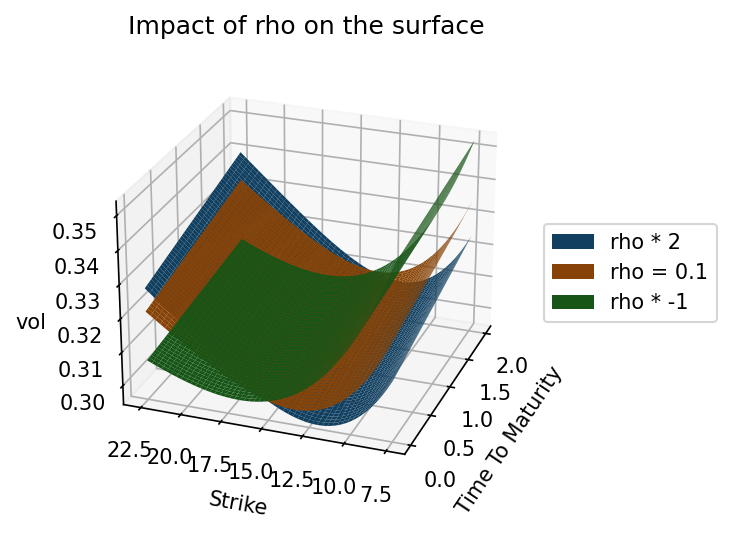

In [50]:
#3.3.1 rho surface 
Z1rho = vol(alpha,beta,nu,rho,Y,price,X)
Z2rho = vol(alpha,beta,nu,rho*2,Y,price,X)
Z0rho = vol(alpha,beta,nu,-rho,Y,price,X)

plt.figure()
ax = plt.axes(projection='3d')
ax.set_xlabel('Time To Maturity')
ax.set_ylabel('Strike')
ax.set_zlabel('vol')
ax.view_init(25, 200)
ax.set_title(f"Impact of rho on the surface")
s2 = ax.plot_surface(X, Y, Z2rho, label = 'rho * 2')
s1 = ax.plot_surface(X, Y, Z1rho, label = f'rho = {rho}')
s0 = ax.plot_surface(X, Y, Z0rho, label = 'rho * -1')
s2._facecolors2d=s2._facecolor3d
s2._edgecolors2d=s2._edgecolor3d
s1._facecolors2d=s1._facecolor3d
s1._edgecolors2d=s1._edgecolor3d
s0._facecolors2d=s0._facecolor3d
s0._edgecolors2d=s0._edgecolor3d
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()  

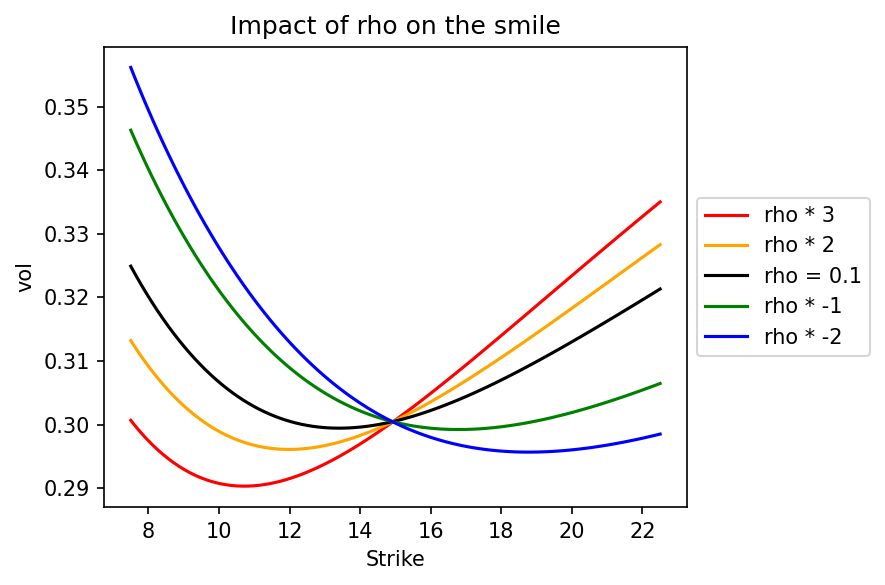

In [49]:
#3.3.2 rho smile 
y1rho = vol(alpha,beta,nu,rho,x1,price,TTM)
y2rho = vol(alpha,beta,nu,rho*2,x1,price,TTM)
y0rho = vol(alpha,beta,nu,rho*-1,x1,price,TTM)
y3rho = vol(alpha,beta,nu,rho*3,x1,price,TTM)
y00rho = vol(alpha,beta,nu,rho*-2,x1,price,TTM)

fig, ax = plt.subplots()
ax.plot(x1,y3rho, 'r',color='red',label = 'rho * 3')
ax.plot(x1,y2rho, 'r',color='orange',label = 'rho * 2')
ax.plot(x1,y1rho, 'r',color = 'black',label = f"rho = {rho}")
ax.plot(x1,y0rho, 'r',color='green',label = 'rho * -1')
ax.plot(x1,y00rho, 'r',color='blue',label = 'rho * -2')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_title(f'Impact of rho on the smile')
ax.set_ylabel('vol')
ax.set_xlabel('Strike')
plt.tight_layout()
plt.show()   

Increasing $\rho$ makes the right part of the smile steeper and the left part flatter. We see that for negative $\rho$, the volatility curve looks more and more like a skew than a smile. We see that changing $\rho$ has no impact on the ATM volatility.

## Impact of nu

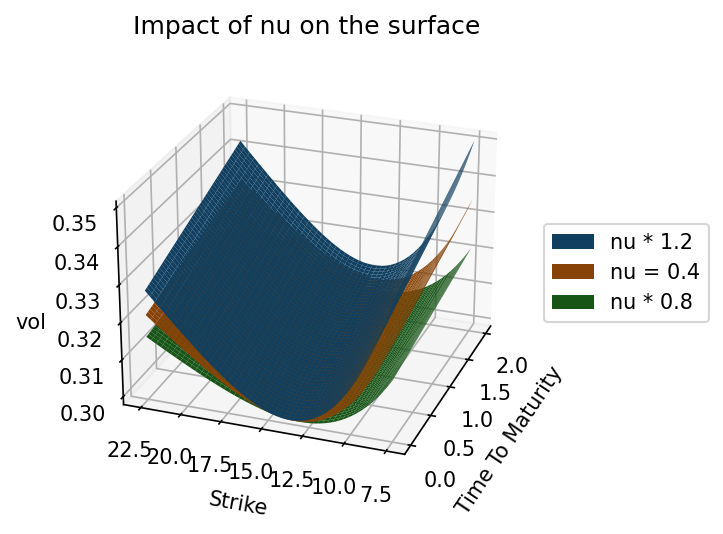

In [52]:
#3.4.1 nu surface
Z1nu = vol(alpha,beta,nu,rho,Y,price,X)
Z2nu = vol(alpha,beta,nu*1.2,rho,Y,price,X)
Z0nu = vol(alpha,beta,nu*0.8,rho,Y,price,X)

plt.figure()
ax = plt.axes(projection='3d')
ax.set_xlabel('Time To Maturity')
ax.set_ylabel('Strike')
ax.set_zlabel('vol')
ax.view_init(25, 200)
ax.set_title(f"Impact of nu on the surface")
s2 = ax.plot_surface(X, Y, Z2nu, label = 'nu * 1.2')
s1 = ax.plot_surface(X, Y, Z1nu, label = f'nu = {nu}')
s0 = ax.plot_surface(X, Y, Z0nu, label = 'nu * 0.8')
s2._facecolors2d=s2._facecolor3d
s2._edgecolors2d=s2._edgecolor3d
s1._facecolors2d=s1._facecolor3d
s1._edgecolors2d=s1._edgecolor3d
s0._facecolors2d=s0._facecolor3d
s0._edgecolors2d=s0._edgecolor3d
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()   

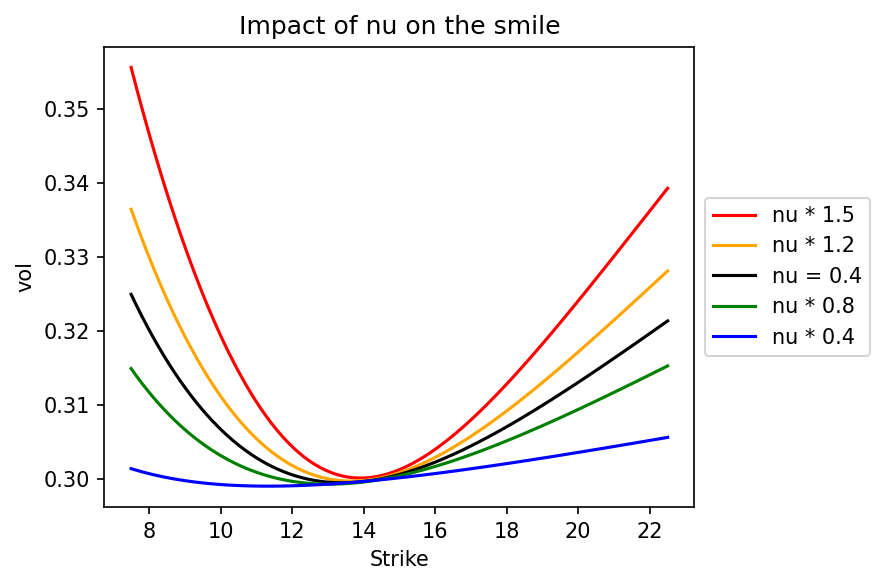

In [51]:
#3.4.2 nu smile
y1nu = vol(alpha,beta,nu,rho,x1,price,TTM)
y2nu = vol(alpha,beta,nu*1.2,rho,x1,price,TTM)
y0nu = vol(alpha,beta,nu*0.8,rho,x1,price,TTM)
y3nu = vol(alpha,beta,nu*1.5,rho,x1,price,TTM)
y00nu = vol(alpha,beta,nu*0.4,rho,x1,price,TTM)

fig, ax = plt.subplots()
ax.plot(x1,y3nu, 'r',color='r',label = 'nu * 1.5')
ax.plot(x1,y2nu, 'r',color='orange',label = 'nu * 1.2')
ax.plot(x1,y1nu, 'r',color = 'black',label = f"nu = {nu}")
ax.plot(x1,y0nu, 'r',color='g',label = 'nu * 0.8')
ax.plot(x1,y00nu, 'r',color='blue',label = 'nu * 0.4')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_title(f'Impact of nu on the smile')
ax.set_ylabel('vol')
ax.set_xlabel('Strike')
plt.tight_layout()
plt.show()  

Larger $\nu$ implies larger volatility and steeper curve on both parts of the smile. On the surface, we can see that, as we get close to maturity, the vertical impact of $\nu$ decreases. For longer time to maturity, there is a vertical shift implied by bigger $\nu$.  

# Monte Carlo implementation
We use the formula in introduction to simulations paths for the future prices. Then we compute the price at time 0 as: 
\begin{align*}
    C_0(f_T,K,r,T) = e^{-rT}E[(f_T-K)^+|\mathcal{F}_0]
\end{align*}
for a European call option with strike K and maturity T, where $f_T$ is the forward price at time T.

In [11]:
def SABRMCprice2(T,f,K,a,b,v,rho,r,NPaths,NSteps):
    dt = T/NSteps
    mean = np.zeros(2)
    cov = np.array([[dt,rho*dt],[rho*dt,dt]])
    a_vec = a*np.ones([NSteps+1,NPaths])
    f_vec = f*np.ones([NSteps+1,NPaths]) 
    for t in range(NSteps):
        dW = np.random.multivariate_normal(mean,cov,NPaths)
        dW1 = dW[:,0]
        dW2 = dW[:,1]
        
        f_vec[t+1,:] = f_vec[t,:] + a_vec[t,:] * (f_vec[t,:] ** b) * dW1
        a_vec[t+1,:] = a_vec[t,:] +  v * a_vec[t,:] * dW2
        
    pv_vec = np.exp(-r*T)*np.maximum(f_vec[-1,:] - K ,0) 
    pv = np.mean(pv_vec)
    
    var_pv = np.var(pv_vec,ddof=1) #Unbiased variance estimator -> ddof = 1 
    sigsqrtn = np.sqrt(var_pv)/np.sqrt(NPaths)
    i1 = pv - 1.96*sigsqrtn
    i2=  pv + 1.96*sigsqrtn
    
    print('----------------------')
    print ("lower boundary: ",i1)
    print ("Higher boundary: ",i2)
    return pv

For each step, the code above simulates a matrix with the NPaths pairs of correlated Brownian motions. Then it computes in a matrix the values of the future price and the volatility at each step. We get the option price by using the conditional expectation above and the Martingale property of the future price under the forward measure. Finally, we compute the empirical variance to compute a 95% confidence of the option price using the Central Limit Theorem.

# Price comparison

First, we implement the function that gives the analytical price of under SABR model. It is the application of Black's formula as said in question 1.

In [15]:
def Analytical(T,f,K,a,b,v,rho,r):
    sigma = vol(a,b,v,rho,K,f,T)
    d1 = (np.log(f/K) + 1/2 * sigma**2 * T )/ (sigma * np.sqrt(T))
    d2 = (np.log(f/K) - 1/2 * sigma**2 * T )/ (sigma * np.sqrt(T))
    price = np.exp(-r*T)* ( f*norm.cdf(d1) - K * norm.cdf(d2))
    return price

## Case 1

Now we use the algorithms above to price a European call option. For the example we choose: 
\begin{align*}
T &= 1 \\ 
K &= 15 \\
\alpha &= 0.3 \\
\beta &= 1 \\
\nu &= 0.4 \\
\rho &= 0.1 \\
r &= 0.1 \\ 
\end{align*}
For the starting prices we choose:
\begin{align*}
ATM &= K +  0.00001  \\
ITM &= K \times 1.5 \\
OTM &= K \times 0.5 \\
\end{align*}
For each Monte Carlo simulation we will do 100 000 paths and 300 steps per year. We choose the ATM forward price close to be $K$ because the analytical formula we implemented cannot take the ATM price as input. Another formula gives the analytical option price for ATM option. 

In [12]:
T = 1 #year
K = 15
alpha = a = 0.3 #a
beta = b = 1 #b
nu = v = 0.4 #v
rho = 0.1 #rho
r = 0.1 #r

NPaths = 100000
NSteps = 300 * T #300 par an

ATM  = K + 0.00001 
ITM = K * 1.2
OTM = K * 0.8

In [63]:
# Print the prices 

print("\n --------- Analytical prices ---------")
print(f'ATM: {Analytical(T,ATM,K,alpha,beta,nu,rho,r)}')
print(f'ITM: {Analytical(T,ITM,K,alpha,beta,nu,rho,r)}')
print(f'OTM: {Analytical(T,OTM,K,alpha,beta,nu,rho,r)}')

#MC Price
print(f"\n ----- MC prices w/o Antithetic variables, {NPaths} simuls, {NSteps} steps-----")
print(f'ATM: {SABRMCprice2(T,ATM,K,alpha,beta,nu,rho,r,NPaths,NSteps)}')
print(f'ITM: {SABRMCprice2(T,ITM,K,alpha,beta,nu,rho,r,NPaths,NSteps)}')
print(f'OTM: {SABRMCprice2(T,OTM,K,alpha,beta,nu,rho,r,NPaths,NSteps)}')


 --------- Analytical prices ---------
ATM: 1.6442436558353515
ITM: 3.47313704357706
OTM: 0.5294770447324666

 ----- MC prices w/o Antithetic variables, 100000 simuls, 300 steps-----
----------------------
lower boundary:  1.6208329624529347
Higher boundary:  1.6605444599711032
ATM: 1.640688711212019
----------------------
lower boundary:  3.4451343641014383
Higher boundary:  3.5018627497061097
ITM: 3.473498556903774
----------------------
lower boundary:  0.5231138811338858
Higher boundary:  0.5455596319749689
OTM: 0.5343367565544274


With the chosen parameters, the call options prices are : 
\begin{align*}
ATM &= 1.6442436558353515 \\
ITM &= 3.47313704357706 \\
OTM &=  0.5294770447324666
\end{align*}
We can see that the Monte Carlo simulations converge to the analytical prices. Still, the convergence is slower than classic Black Scholes model with fixed volatility. This is due to additional variance added by the volatility diffusion. 

## Case 2

Now we use the algorithms above to price a European call option. For the example we choose: 
\begin{align*}
T &= 2 \\ 
K &= 300 \\
\alpha &= 0.4 \\
\beta &= 1 \\
\nu &= 0.3 \\
\rho &= -0.1 \\
r &= 0.05 \\ 
\end{align*}
For the starting prices we choose:
\begin{align*}
ATM &= K +  0.00001  \\
ITM &= K \times 1.5 \\
OTM &= K \times 0.5 \\
\end{align*}

In [22]:
T = 2 #year
K = 300
alpha = a = 0.4 #a
beta = b = 1 #b
nu = v = 0.3 #v
rho = -0.1 #rho
r = 0.05 #r

NPaths = 100000
NSteps = 600 * T #600 par an

ATM  = K + 0.00001 
ITM = K * 1.2
OTM = K * 0.8

In [23]:
# Print the prices 

print("\n --------- Analytical prices ---------")
print(f'ATM: {Analytical(T,ATM,K,alpha,beta,nu,rho,r)}')
print(f'ITM: {Analytical(T,ITM,K,alpha,beta,nu,rho,r)}')
print(f'OTM: {Analytical(T,OTM,K,alpha,beta,nu,rho,r)}')

#MC Price
print(f"\n ----- MC prices w/o Antithetic variables, {NPaths} simuls, {NSteps} steps-----")
print(f'ATM: {SABRMCprice2(T,ATM,K,alpha,beta,nu,rho,r,NPaths,NSteps)}')
print(f'ITM: {SABRMCprice2(T,ITM,K,alpha,beta,nu,rho,r,NPaths,NSteps)}')
print(f'OTM: {SABRMCprice2(T,OTM,K,alpha,beta,nu,rho,r,NPaths,NSteps)}')


 --------- Analytical prices ---------
ATM: 60.969193376090054
ITM: 98.11069575934992
OTM: 31.555394784069456

 ----- MC prices w/o Antithetic variables, 100000 simuls, 1200 steps-----
----------------------
lower boundary:  59.87408819424951
Higher boundary:  61.579661540233744
ATM: 60.72687486724163
----------------------
lower boundary:  97.0166474849142
Higher boundary:  99.23516995700915
ITM: 98.12590872096168
----------------------
lower boundary:  30.711307777792484
Higher boundary:  31.87056569270562
OTM: 31.29093673524905


For this example also we can see that the Monte Carlo simulations converges. In this example, we simulated 100 000 paths with 600 steps per year instead of 300. We see that the confidence interval is bigger in this example.  